In [ ]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

# Project 9: Support Vector Machines — Margin Maximization

## Goal
Build SVM intuition; understand margin, kernel methods, and C regularization.

## Learning Objectives
- Derive the SVM objective: maximize margin, minimize violations
- Understand support vectors and decision boundaries
- Visualize kernel effects (linear, RBF, polynomial)
- Tune C hyperparameter via cross-validation
- Compare SVM to linear/logistic regression

## Prerequisites
- Projects 1–8

## What You'll Build
- SVM classifier; decision boundary plots; kernel visualizations

## Estimated Time
- 3–5 hours (emphasizes conceptual understanding, not implementation from scratch)

---

# Project 9: Support Vector Machines

## Goal
Understand margin maximization and kernel methods.

## Learning Objectives
- What is the margin?
- Support vectors and decision boundary
- Kernel trick and RBF kernel
- C parameter (regularization)

In [24]:
# Setup (portable path)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    base = Path.cwd().resolve()
    for candidate in [base] + list(base.parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification, make_circles

print("Ready to explore SVMs!")

Repo root: /Users/mark/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to explore SVMs!


In [25]:
# 1) Generate linearly separable and non-linearly separable datasets
np.random.seed(42)
# Linearly separable (simple binary classification)
X_linear, y_linear = make_classification(n_samples=200, n_features=2, n_informative=2, 
                                         n_redundant=0, n_clusters_per_class=1, 
                                         class_sep=1.5, flip_y=0, random_state=42)
# Non-linearly separable (concentric circles)
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)
print('Linear dataset shape:', X_linear.shape)
print('Circles dataset shape:', X_circles.shape)

Linear dataset shape: (200, 2)
Circles dataset shape: (300, 2)


In [26]:
# 2) Helper function to plot decision boundaries and support vectors
def plot_svm_decision_boundary(X, y, model, title='SVM Decision Boundary'):
    h = 0.02  # mesh step
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm', s=30)
    
    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=100, linewidth=1.5, facecolors='none', edgecolors='green', label='Support Vectors')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
print('Helper function defined.')

Helper function defined.


Number of support vectors: 39
Support vector indices: [  5   7  11  15  23  30  39  41  46  47  66  84  85 109 125 140 161 173
 176 199   0   6  25  74  76  92  97 100 114 118 119 120 121 126 144 150
 155 156 190]


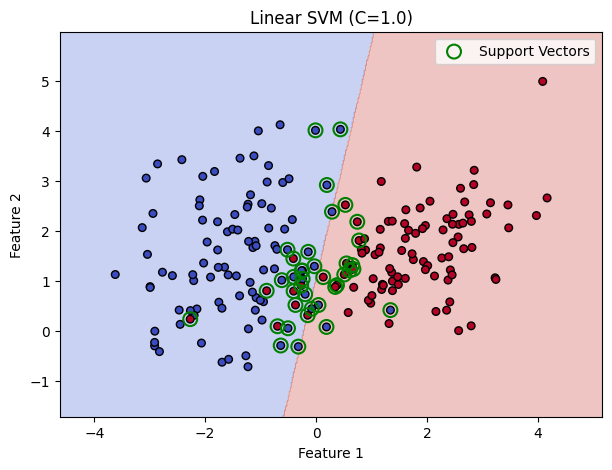

In [27]:
# 3) Linear SVM on linearly separable data
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_linear, y_linear)
print(f'Number of support vectors: {len(svm_linear.support_vectors_)}')
print(f'Support vector indices: {svm_linear.support_}')
plt.figure(figsize=(7,5))
plot_svm_decision_boundary(X_linear, y_linear, svm_linear, title='Linear SVM (C=1.0)')
plt.show()

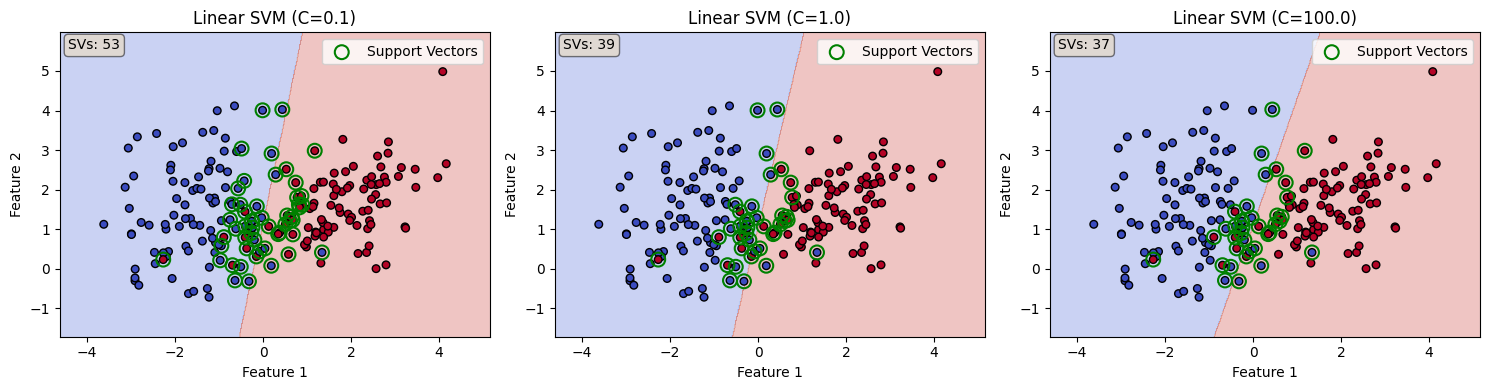

Small C: larger margin, more support vectors (softer margin)
Large C: narrower margin, fewer support vectors (harder margin, risk overfitting)


In [28]:
# 4) Effect of C parameter (soft margin)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
C_values = [0.1, 1.0, 100.0]
for ax, C in zip(axes, C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_linear, y_linear)
    plt.sca(ax)
    plot_svm_decision_boundary(X_linear, y_linear, svm, title=f'Linear SVM (C={C})')
    ax.text(0.02, 0.98, f'SVs: {len(svm.support_vectors_)}', 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()
print('Small C: larger margin, more support vectors (softer margin)')
print('Large C: narrower margin, fewer support vectors (harder margin, risk overfitting)')

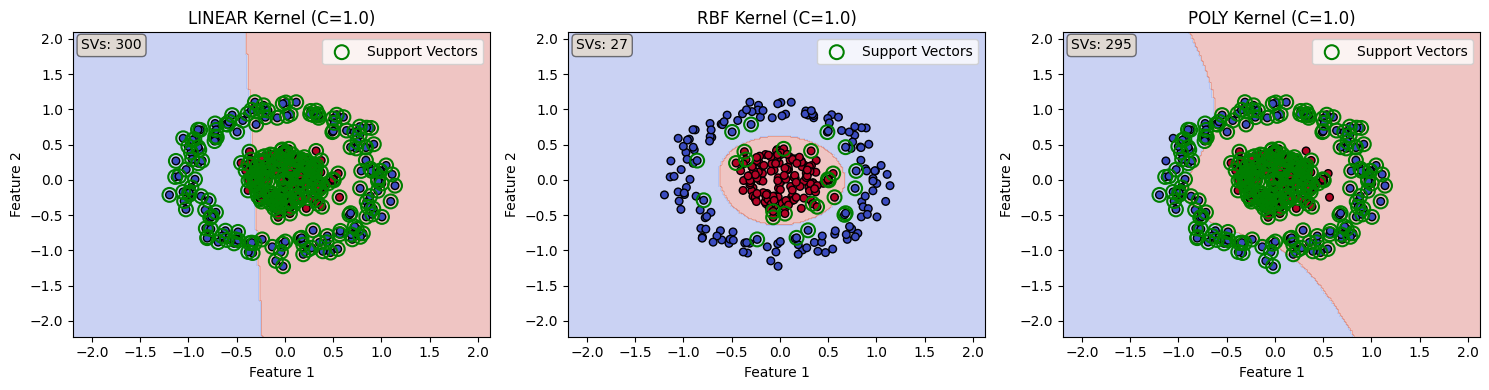

Linear kernel cannot separate circles; RBF and poly kernels succeed via kernel trick.


In [29]:
# 5) Kernel trick: RBF and Polynomial kernels on non-linear data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
kernels = ['linear', 'rbf', 'poly']
for ax, kernel in zip(axes, kernels):
    svm = SVC(kernel=kernel, C=1.0, gamma='scale', degree=3)
    svm.fit(X_circles, y_circles)
    plt.sca(ax)
    plot_svm_decision_boundary(X_circles, y_circles, svm, title=f'{kernel.upper()} Kernel (C=1.0)')
    ax.text(0.02, 0.98, f'SVs: {len(svm.support_vectors_)}', 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()
print('Linear kernel cannot separate circles; RBF and poly kernels succeed via kernel trick.')

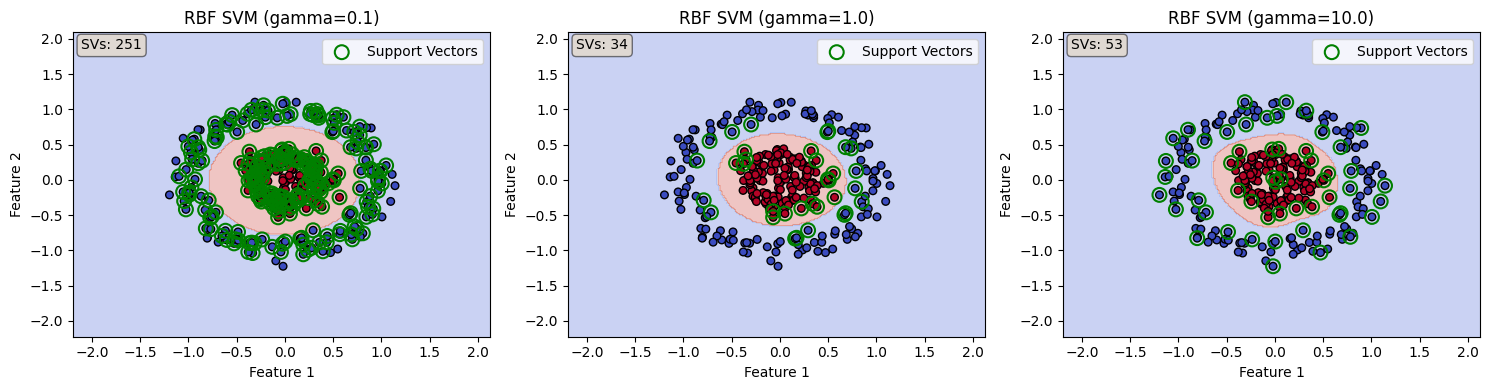

Small gamma: smooth boundary (underfitting risk)
Large gamma: tight boundary around each point (overfitting risk)


In [30]:
# 6) Effect of gamma parameter in RBF kernel
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
gamma_values = [0.1, 1.0, 10.0]
for ax, gamma in zip(axes, gamma_values):
    svm = SVC(kernel='rbf', C=1.0, gamma=gamma)
    svm.fit(X_circles, y_circles)
    plt.sca(ax)
    plot_svm_decision_boundary(X_circles, y_circles, svm, title=f'RBF SVM (gamma={gamma})')
    ax.text(0.02, 0.98, f'SVs: {len(svm.support_vectors_)}', 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()
print('Small gamma: smooth boundary (underfitting risk)')
print('Large gamma: tight boundary around each point (overfitting risk)')

In [31]:
# 7) Compare SVM variants: SVC vs LinearSVC vs SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import time

# Use linear dataset for fair comparison
variants = {
    'SVC(linear)': SVC(kernel='linear', C=1.0),
    'LinearSVC': LinearSVC(C=1.0, max_iter=10000, dual=True),
    'SGDClassifier': make_pipeline(StandardScaler(), SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))
}

results = []
for name, model in variants.items():
    start = time.time()
    scores = cross_val_score(model, X_linear, y_linear, cv=5, scoring='accuracy')
    elapsed = time.time() - start
    results.append({'variant': name, 'mean_acc': scores.mean(), 'std': scores.std(), 'time_s': elapsed})
    print(f'{name}: {scores.mean():.3f} ± {scores.std():.3f}, time: {elapsed:.3f}s')

import pandas as pd
res_variants = pd.DataFrame(results)
res_variants

SVC(linear): 0.920 ± 0.051, time: 0.004s
LinearSVC: 0.935 ± 0.046, time: 0.004s
SGDClassifier: 0.890 ± 0.051, time: 0.004s


,variant,mean_acc,std,time_s
0,SVC(linear),0.920,0.050990,0.004429
1,LinearSVC,0.935,0.046368,0.003918
2,SGDClassifier,0.890,0.051478,0.004086


Best params: {'C': 0.1, 'gamma': 1}
Best CV accuracy: 1.0


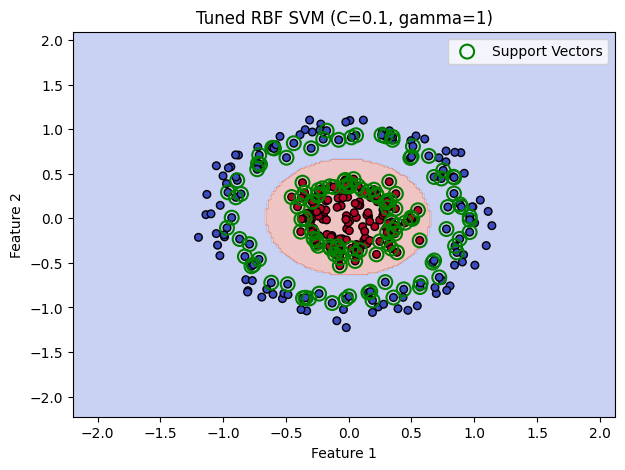

In [32]:
# 8) GridSearchCV for optimal C and gamma on RBF kernel
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_circles, y_circles)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', grid.best_score_)
best_svm = grid.best_estimator_
plt.figure(figsize=(7,5))
plot_svm_decision_boundary(X_circles, y_circles, best_svm, 
                            title=f'Tuned RBF SVM (C={best_svm.C}, gamma={best_svm.gamma})')
plt.show()

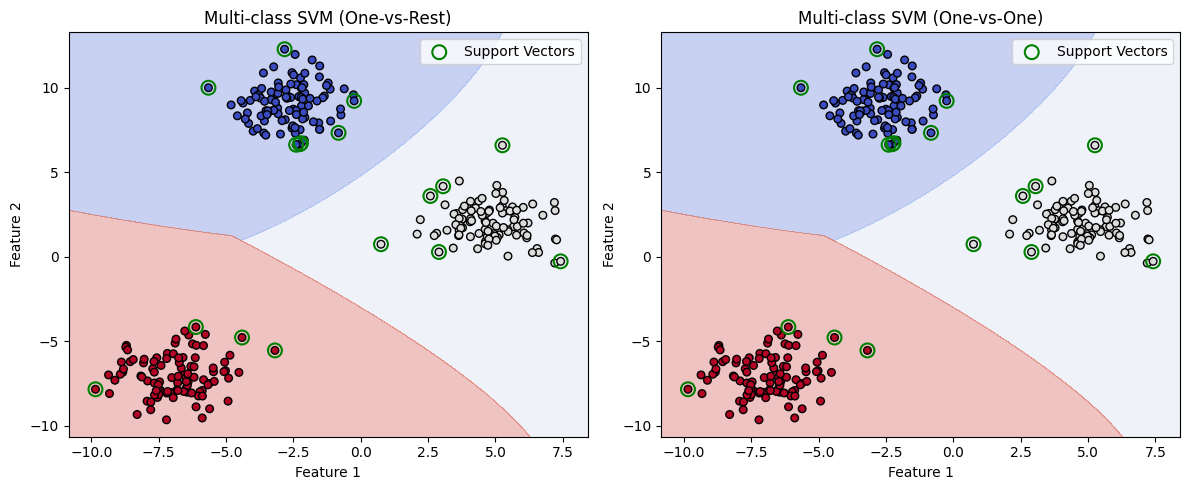

Multi-class SVMs use one-vs-rest or one-vs-one strategies internally.


In [33]:
# 9) Multi-class SVM (one-vs-rest and one-vs-one)
from sklearn.datasets import make_blobs
X_multi, y_multi = make_blobs(n_samples=300, centers=3, n_features=2, cluster_std=1.2, random_state=42)

# Default is one-vs-rest (ovr)
svm_ovr = SVC(kernel='rbf', decision_function_shape='ovr')
svm_ovr.fit(X_multi, y_multi)

# One-vs-one (ovo)
svm_ovo = SVC(kernel='rbf', decision_function_shape='ovo')
svm_ovo.fit(X_multi, y_multi)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, model, title in zip(axes, [svm_ovr, svm_ovo], ['One-vs-Rest', 'One-vs-One']):
    plt.sca(ax)
    plot_svm_decision_boundary(X_multi, y_multi, model, title=f'Multi-class SVM ({title})')
plt.tight_layout()
plt.show()
print('Multi-class SVMs use one-vs-rest or one-vs-one strategies internally.')

In [34]:
# 10) Persist trained models and results
import joblib
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

# Save best RBF model
joblib.dump(best_svm, out_dir / 'svm_rbf_tuned.pkl')

# Save variant comparison results
res_variants.to_csv(out_dir / 'svm_variants_comparison.csv', index=False)

# Save grid search results
grid_results = pd.DataFrame(grid.cv_results_)
grid_results[['param_C','param_gamma','mean_test_score','std_test_score']].to_csv(
    out_dir / 'svm_gridsearch_results.csv', index=False)

print('Saved: svm_rbf_tuned.pkl, svm_variants_comparison.csv, svm_gridsearch_results.csv')

Saved: svm_rbf_tuned.pkl, svm_variants_comparison.csv, svm_gridsearch_results.csv


In [35]:
# 11) Interpretation & Key Takeaways
from IPython.display import Markdown, display
display(Markdown(r'''
### Interpretation & Key Takeaways

**What are Support Vector Machines?**
- SVMs find the optimal separating hyperplane that maximizes the margin between classes.
- The **margin** is the distance from the hyperplane to the nearest data points (support vectors).
- Only support vectors influence the decision boundary; other points are ignored.

**Hyperparameters**
- **C (regularization)**: Controls trade-off between margin width and classification error.
  - Small C → wider margin, more support vectors, tolerates misclassification (soft margin).
  - Large C → narrower margin, fewer support vectors, minimizes misclassification (hard margin, overfitting risk).
- **gamma (RBF kernel)**: Controls influence radius of a single training example.
  - Small gamma → smooth, broad decision boundary (underfitting risk).
  - Large gamma → tight boundary around each point (overfitting risk).

**Kernel Trick**
- Linear kernel: works only for linearly separable data.
- RBF (Radial Basis Function): most popular for non-linear data; implicitly maps to infinite dimensions.
- Polynomial: can model polynomial decision boundaries; requires tuning degree.

**When to Use SVMs**
- Small to medium-sized datasets (SVMs don't scale well to very large datasets).
- High-dimensional data (text, images with extracted features).
- Clear margin of separation exists or suspected.
- When interpretability of individual features is less critical than prediction accuracy.

**SVM Variants**
- **SVC**: Full kernel support, slower on large data.
- **LinearSVC**: Optimized for linear kernel, faster, scales better.
- **SGDClassifier**: Stochastic gradient descent; very fast, approximate, good for large-scale linear problems.

**Multi-class**
- One-vs-Rest (OvR): Train K binary classifiers (one per class).
- One-vs-One (OvO): Train K(K-1)/2 classifiers (one per pair); more robust but computationally expensive.

**Rules of Thumb**
1. Start with RBF kernel and tune C and gamma via GridSearchCV.
2. Use LinearSVC or SGDClassifier for large, high-dimensional linear problems.
3. Always scale features (StandardScaler) before training SVMs.
4. Regularize carefully; small C for noisy data, large C for clean data.
5. For imbalanced data, use class_weight='balanced' parameter.
'''))


### Interpretation & Key Takeaways

**What are Support Vector Machines?**
- SVMs find the optimal separating hyperplane that maximizes the margin between classes.
- The **margin** is the distance from the hyperplane to the nearest data points (support vectors).
- Only support vectors influence the decision boundary; other points are ignored.

**Hyperparameters**
- **C (regularization)**: Controls trade-off between margin width and classification error.
  - Small C → wider margin, more support vectors, tolerates misclassification (soft margin).
  - Large C → narrower margin, fewer support vectors, minimizes misclassification (hard margin, overfitting risk).
- **gamma (RBF kernel)**: Controls influence radius of a single training example.
  - Small gamma → smooth, broad decision boundary (underfitting risk).
  - Large gamma → tight boundary around each point (overfitting risk).

**Kernel Trick**
- Linear kernel: works only for linearly separable data.
- RBF (Radial Basis Function): most popular for non-linear data; implicitly maps to infinite dimensions.
- Polynomial: can model polynomial decision boundaries; requires tuning degree.

**When to Use SVMs**
- Small to medium-sized datasets (SVMs don't scale well to very large datasets).
- High-dimensional data (text, images with extracted features).
- Clear margin of separation exists or suspected.
- When interpretability of individual features is less critical than prediction accuracy.

**SVM Variants**
- **SVC**: Full kernel support, slower on large data.
- **LinearSVC**: Optimized for linear kernel, faster, scales better.
- **SGDClassifier**: Stochastic gradient descent; very fast, approximate, good for large-scale linear problems.

**Multi-class**
- One-vs-Rest (OvR): Train K binary classifiers (one per class).
- One-vs-One (OvO): Train K(K-1)/2 classifiers (one per pair); more robust but computationally expensive.

**Rules of Thumb**
1. Start with RBF kernel and tune C and gamma via GridSearchCV.
2. Use LinearSVC or SGDClassifier for large, high-dimensional linear problems.
3. Always scale features (StandardScaler) before training SVMs.
4. Regularize carefully; small C for noisy data, large C for clean data.
5. For imbalanced data, use class_weight='balanced' parameter.


## Exercises & Extensions

**Warm-up**:
1. Visualize SVM with different C values. How do margins and misclassifications change?
2. Support vectors: which training samples determine the decision boundary?
3. Linear vs RBF kernel: when should you use each?

**Intermediate**:
4. Grid search for C and kernel gamma. Compare CV scores.
5. Imbalanced data: use class_weight='balanced' to penalize minority class errors more.
6. Plot decision boundary for RBF kernel. How complex can the boundary be?

**Advanced**:
7. Implement custom kernel (e.g., polynomial degree tuning).
8. One-class SVM for anomaly detection.
9. Compare SVM vs logistic regression on same dataset. Which generalizes better?

---

## Summary & Bridge Forward

**What you learned**:
- SVM maximizes margin: maximize distance between hyperplane and data points.
- Soft margin (C): controls overfitting vs underfitting.
- Kernels enable nonlinear boundaries without explicitly computing high-dimensional features.
- Support vectors are the critical training points.
- Scaling features matters for SVM.

**Why this matters**:
- SVMs are among the most powerful classical ML methods.
- Kernel trick inspired modern deep learning (implicit feature maps).
- RBF kernels can fit arbitrarily complex boundaries (but may overfit).

**Next project** (Feature Engineering):
- Manual feature design to improve model performance.
- Interactions, polynomials, domain-specific features.

**Your takeaway**: Margins and kernels are two powerful ideas. Margin maximization generalizes; kernels enable nonlinearity.